In [1]:
# enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
# exit at 1h rsi 74 overbought
# stop loss 2 atr
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)


In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import pandas_ta as p_ta
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import os

In [4]:
from binance.client import Client
from dotenv import load_dotenv

# Get the path to the current directory
current_directory = os.getcwd()

# Specify the path to the .env file relative to the current directory
dotenv_path = os.path.join(current_directory, '.env')

# Load the environment variables from the .env file
load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')
api_secret = os.getenv('SECRET_KEY')

client = Client(api_key, api_secret, testnet = False)

In [5]:
interval_arr = ['15m', '1h', '4h']
start_time_arr = [1651366861000]
ema_arr = [8, 18, 38]

In [6]:
timezone = 8
symbol = 'ethusdt'
interval = '1h'


start_time = 1635743450000
end_time = round(time.time() * 1000)

def def_time():
    global start_time, end_time
    start_time = 1635743450000
    end_time = round(time.time() * 1000)
    # end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [7]:
dataframes = {}
# 先抓歷史資料好讓技術指標能成型
def create_raw(symbol, interval_arr, step):
    global start_time, end_time
    # Fetch the data using batch requests
    for interval in interval_arr:
        def_time()
        data = []    
        while start_time < end_time:
            
            limit = min(step, end_time - start_time + 1)  # Adjust the limit for the last batch
            response = client.get_klines(symbol=symbol.upper(), interval=interval, limit=limit, startTime=start_time)

            if len(response) == 0:
                break  # No more data available, exit the loop
            data.extend(response)
            start_time = response[-1][0] + 1

            # Convert the data to a DataFrame
        columns = [
            "Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time",
            "Quote asset volume", "Number of trades", "Taker buy base asset volume",
            "Taker buy quote asset volume", "Ignore"
        ]
        raw_df = pd.DataFrame(data, columns=columns)   

        raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]

        dataframes[f'df_{interval}'] = raw_df

In [8]:
loop_start_time = time.time()
create_raw(symbol, interval_arr, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
print(dataframes)

Time taken to execute for loop: 7.129378080368042 seconds
{'df_15m':            Open_Time           Open          Close           High  \
0      1635743700000  4233.64000000  4238.15000000  4246.31000000   
1      1635744600000  4238.16000000  4251.22000000  4251.54000000   
2      1635745500000  4251.23000000  4225.00000000  4252.58000000   
3      1635746400000  4225.00000000  4209.00000000  4225.99000000   
4      1635747300000  4208.99000000  4232.36000000  4234.21000000   
...              ...            ...            ...            ...   
55762  1685934000000  1875.00000000  1871.55000000  1875.00000000   
55763  1685934900000  1871.55000000  1874.99000000  1874.99000000   
55764  1685935800000  1874.99000000  1872.99000000  1874.99000000   
55765  1685936700000  1873.00000000  1869.65000000  1873.00000000   
55766  1685937600000  1869.64000000  1869.66000000  1869.66000000   

                 Low          Volume  
0      4231.60000000   2158.18360000  
1      4238.14000000   3

In [9]:
def get_klines(symbol, interval):
    global dataframes
    df = dataframes[f'df_{interval}']
    df = df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)
    df = df.set_index('Open_Time')

    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [10]:
def time_format(timezone):
#     df['Open_Time'] = pd.to_datetime(df[''], unit='ms') + pd.Timedelta(hours=timezone)
#     df['Open_Time'] = df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
bb_int = 30
bb_dev = 2
rsi_int = 18

In [12]:
df = get_klines(symbol, interval_arr[0]).copy()
df = df.astype(float).round(4)

for interval in interval_arr:
    raw_df = get_klines(symbol, interval)
    
    # ema
    for ema in ema_arr:
        column_name = f'ema_{ema}_{interval}'
        df[column_name] = ta.trend.ema_indicator(raw_df.Close, window=ema)
    
    # bb
    bb = ta.volatility.BollingerBands(raw_df.Close, window=bb_int, window_dev=bb_dev)
    df[f'bb_u_{interval}'] = bb.bollinger_hband()
    df[f'bb_m_{interval}'] = bb.bollinger_mavg()
    df[f'bb_l_{interval}'] = bb.bollinger_lband()        

    # rsi
    rsi = ta.momentum.RSIIndicator(raw_df.Close, window = rsi_int)
    df[f'rsi_{interval}'] = rsi.rsi()
    
    # atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# reset index and set current index as a column
df = df.reset_index()

# set new index with integers
df = df.set_index(pd.RangeIndex(len(df)))

# time_format(timezone)
df['Open_Time'] = df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

print(df)
df.to_csv('df.csv')

                 Open_Time     Open    Close     High      Low      Volume  \
0      2021-11-01 13:15:00  4233.64  4238.15  4246.31  4231.60   2158.1836   
1      2021-11-01 13:30:00  4238.16  4251.22  4251.54  4238.14   3168.4890   
2      2021-11-01 13:45:00  4251.23  4225.00  4252.58  4220.00   4596.0605   
3      2021-11-01 14:00:00  4225.00  4209.00  4225.99  4203.16   4048.4310   
4      2021-11-01 14:15:00  4208.99  4232.36  4234.21  4198.55   3627.5485   
...                    ...      ...      ...      ...      ...         ...   
55762  2023-06-05 11:00:00  1875.00  1871.55  1875.00  1869.98  12792.8036   
55763  2023-06-05 11:15:00  1871.55  1874.99  1874.99  1866.62   7369.4140   
55764  2023-06-05 11:30:00  1874.99  1872.99  1874.99  1871.00   2574.2046   
55765  2023-06-05 11:45:00  1873.00  1869.65  1873.00  1867.42   3793.3887   
55766  2023-06-05 12:00:00  1869.64  1869.66  1869.66  1865.50   1476.0360   

         ema_8_15m   ema_18_15m   ema_38_15m     bb_u_15m  ... 

In [13]:
# enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
# exit at 1h rsi 74 overbought
# stop loss 2 atr

In [14]:
rsi_up = 72
rsi_low = 40
kd_dir = 'Up'

In [15]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# # ema
#     for i in (8, 18, 38):
#         df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# # bband
#     bb_int = 30
#     bb_dev = 2
#     bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
#     df['bb_u'] = bb.bollinger_hband()
#     df['bb_m'] = bb.bollinger_mavg()
#     df['bb_l'] = bb.bollinger_lband()        
        
# # atr
#     df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# # rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    df['slow_k']= ta.momentum.stoch(df['High'], df['Low'], df['Close'], 17, 5)
    df['slow_d'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'], 17, 5)
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [16]:
indicators(df, kd_dir)

In [17]:
df = df.replace('', np.nan)
df['ema_8_4h'] = df['ema_8_4h'].interpolate()
df['ema_38_4h'] = df['ema_38_4h'].interpolate()
df['rsi_1h'] = df['rsi_1h'].interpolate()
print(df['rsi_1h'])

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
55762    29.764361
55763    29.757064
55764    29.749767
55765    29.742469
55766    29.735172
Name: rsi_1h, Length: 55767, dtype: float64


In [18]:
def conditions(df):
    # enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
    # exit at 1h rsi 74 overbought
    # stop loss 2 atr
    
    df['c1'] = False
    for i, row in df.iterrows():
        if i >= 10:
            if (df.loc[i-10:i-1, 'rsi_1h'] < rsi_low).any():
                df.loc[i, 'c1'] = True
                
    df['c2'] = df['kd_cross']

    df['c3'] = df[f'ema_{ema_arr[0]}_4h'] >= df[f'ema_{ema_arr[2]}_4h']

    df['c4'] = df[f'ema_{ema_arr[0]}_4h'] >= df[f'ema_{ema_arr[1]}_4h']



    # 條件達成
    df['signal'] = df.c1 & df.c2 & df.c3 & df.c4

#     print(df)

    # 下一根進場
    df['open_entry'] = df['signal'].shift()

    return df

In [19]:
conditions(df)

,Open_Time,Open,Close,High,Low,Volume,ema_8_15m,ema_18_15m,ema_38_15m,bb_u_15m,...,rsi_4h,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_entry
0,2021-11-01 13:15:00,4233.64,4238.15,4246.31,4231.60,2158.1836,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,NaN
1,2021-11-01 13:30:00,4238.16,4251.22,4251.54,4238.14,3168.4890,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2021-11-01 13:45:00,4251.23,4225.00,4252.58,4220.00,4596.0605,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2021-11-01 14:00:00,4225.00,4209.00,4225.99,4203.16,4048.4310,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2021-11-01 14:15:00,4208.99,4232.36,4234.21,4198.55,3627.5485,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55762,2023-06-05 11:00:00,1875.00,1871.55,1875.00,1869.98,12792.8036,1880.286419,1885.785073,1891.751280,1914.883729,...,NaN,7.731234,20.725395,False,True,False,True,False,False,False
55763,2023-06-05 11:15:00,1871.55,1874.99,1874.99,1866.62,7369.4140,1879.109437,1884.648750,1890.891727,1914.486490,...,NaN,23.007147,19.717850,True,True,True,True,False,False,False
55764,2023-06-05 11:30:00,1874.99,1872.99,1874.99,1871.00,2574.2046,1877.749562,1883.421513,1889.973690,1913.973307,...,NaN,24.757093,18.942773,False,True,False,True,False,False,False
55765,2023-06-05 11:45:00,1873.00,1869.65,1873.00,1867.42,3793.3887,1875.949659,1881.971880,1888.931449,1913.547671,...,NaN,11.776137,16.698697,False,True,False,True,False,False,False


In [20]:
sl_atr = 5

In [21]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
#         entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
#         take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position and (entry_df.at[index, 'rsi_1h'] >= rsi_up):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
#         take_profit = np.nan
        entry_df.at[index, 'take_profit'] = close_val.at[index]
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry']) | (entry_df['position'] != '')]


print(entry_df)

                 Open_Time     Open    Close     High      Low      Volume  \
1      2021-11-01 13:30:00  4238.16  4251.22  4251.54  4238.14   3168.4890   
2      2021-11-01 13:45:00  4251.23  4225.00  4252.58  4220.00   4596.0605   
3      2021-11-01 14:00:00  4225.00  4209.00  4225.99  4203.16   4048.4310   
4      2021-11-01 14:15:00  4208.99  4232.36  4234.21  4198.55   3627.5485   
5      2021-11-01 14:30:00  4232.37  4246.87  4259.14  4231.96   4299.7560   
...                    ...      ...      ...      ...      ...         ...   
55762  2023-06-05 11:00:00  1875.00  1871.55  1875.00  1869.98  12792.8036   
55763  2023-06-05 11:15:00  1871.55  1874.99  1874.99  1866.62   7369.4140   
55764  2023-06-05 11:30:00  1874.99  1872.99  1874.99  1871.00   2574.2046   
55765  2023-06-05 11:45:00  1873.00  1869.65  1873.00  1867.42   3793.3887   
55766  2023-06-05 12:00:00  1869.64  1869.66  1869.66  1865.50   1476.0360   

         ema_8_15m   ema_18_15m   ema_38_15m     bb_u_15m  ... 

In [22]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位 usdt
pos_size = 200

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'rsi_4h', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size / pos.at[index, 'entry_p']
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
#                 break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


cumulative_values = []
cumulative_sum = 0

for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

max_drawdown = min(cumulative_values)
    
# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate],
          'Max_Drawdown': [round(max_drawdown,2)]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit   Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0   14.05  2.41        22.0      -7.3          1         200.0   70.25%   

  Win_Rate  Max_Drawdown  
0   41.67%        -19.73  

              Open_Time     Open    Close     High      Low     rsi_4h  \
0   2021-11-11 04:15:00  4694.45  4700.00  4722.00  4685.20        NaN   
1   2021-11-13 00:15:00  4587.46  4527.62  4600.00  4523.81        NaN   
2   2021-12-26 12:15:00  4026.02  4014.08  4030.82  4012.72        NaN   
3   2021-12-28 12:15:00  3932.91  3900.01  3933.45  3877.00        NaN   
4   2022-01-14 08:15:00  3251.12  3240.88  3256.63  3239.09        NaN   
5   2022-01-18 05:30:00  3168.51  3157.55  3172.25  3153.31        NaN   
6   2022-03-21 00:15:00  2859.58  2863.02  2878.00  2857.23        NaN   
7   2022-03-28 04:00:00  3175.81  3174.16  3178.59  3172.53  74.186346   
8   2022-04-05 00:15:00  3442.64  3446.87  3452.02  3440.71        NaN   
9   2022-04-06 08:00:00  3407.00  3316.95  3407.50  33

In [23]:
plt_df = pos[['Open_Time', 'position', 'amt']]

cumulative_sum = 0
agg_amts = []
stop_date = None

for index, row in plt_df.iterrows():
    if row['position'] == 'Buy':
        cumulative_sum += row['amt']
    elif row['position'] == 'Stop' or row['position'] == 'Sell':
        cumulative_sum += row['amt']
        stop_date = row['Open_Time']
        agg_amts.append((stop_date, cumulative_sum))
        cumulative_sum = 0

        
# Convert the list of tuples into a new dataframe
agg_df = pd.DataFrame(agg_amts, columns=['date', 'cumulative_sum'])
agg_df['cumulative_sum'] = agg_df['cumulative_sum'].apply(lambda x: -x)

print(agg_df['cumulative_sum'].sum())
print(agg_df)

16.45840000000001
                   date  cumulative_sum
0   2021-11-13 00:15:00         -7.1075
1   2021-12-28 12:15:00         -6.2598
2   2022-01-18 05:30:00         -5.7729
3   2022-03-28 04:00:00         22.0026
4   2022-04-06 08:00:00         -7.3020
5   2022-10-07 20:30:00         -2.7103
6   2022-10-29 16:00:00         13.7661
7   2023-02-02 06:30:00          6.5608
8   2023-02-22 14:30:00         -4.7015
9   2023-03-29 16:00:00          7.2825
10  2023-04-13 16:15:00          6.4467
11  2023-05-09 01:45:00         -5.7463


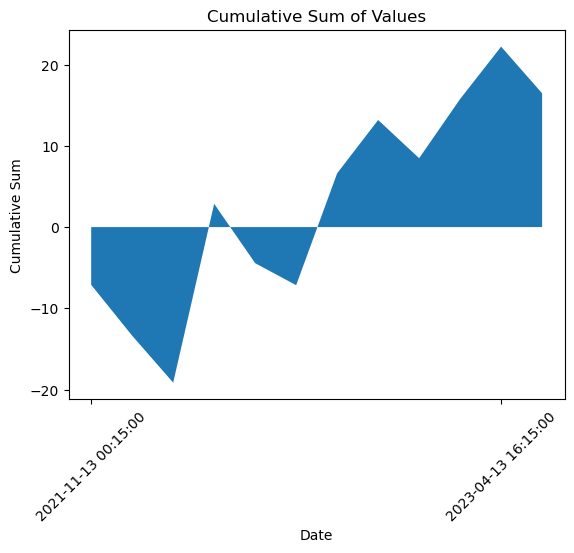

-19.730629899999983


In [24]:
cumulative_values = []
cumulative_sum = 0
for value in agg_df['cumulative_sum']:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(agg_df['date'], cumulative_values, 0)

plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')


n = 10  # Adjust the value of n as per your preference
plt.xticks(agg_df['date'][::n], rotation=45)
plt.show()

print(max_drawdown)
# print(cumulative_values)

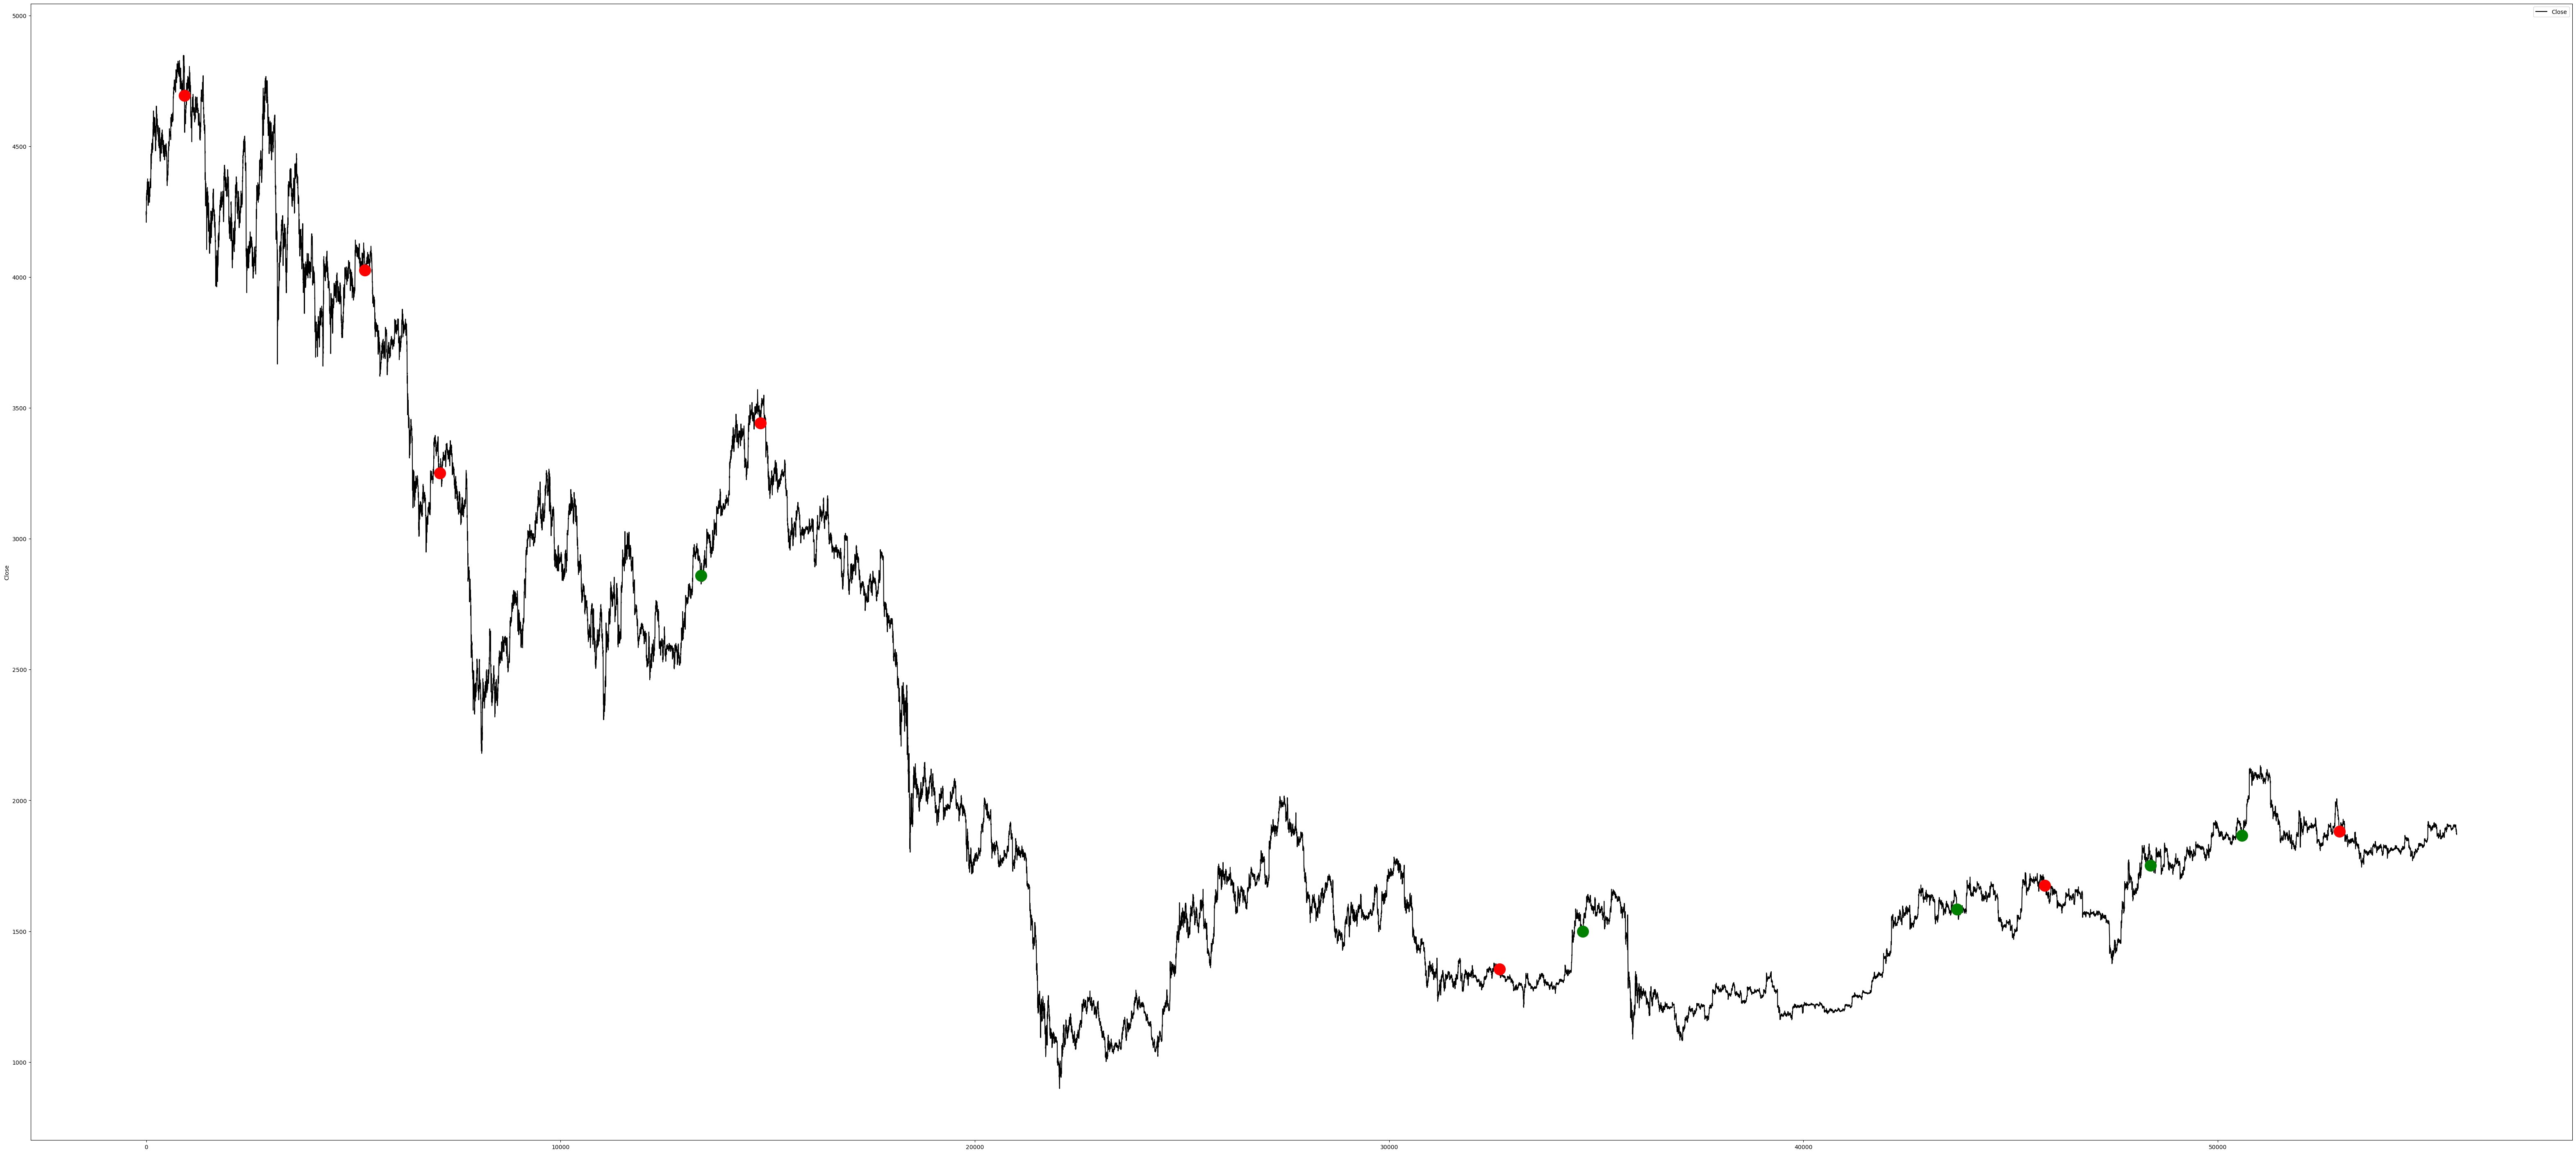

In [25]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位